# Drift correction

...for GPS tracks collected on drifting sea ice.

### needed:
- a mobile GPS track with X and Y (long, lat) coordinate pairs which needs drift removed
- a reference GPS track which contains the drift to be removed (eg from a fixed-to-floe GPS)

### basic strategy:
1. collect a common time window between the reference and mobile GPS track
2. choose a projected coordinate system expressed in meters, and reproject both GPS tracks to it
3. if one track has a higher time resolution, interpolate the other track so that both tracks have the same time resolution
4. subtract the reference track positions from the mobile track positions

### caveat:

This strategy assumes the ice floe has not rotated significantly during the survey.

In [1]:
## import all the libraries

# standard stuff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime, timedelta

# reprojection help
import pyproj
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info

# xml help for GPX files
import xml.etree.ElementTree as et

# cartopy, basemap is deprecated

In [2]:
## functions we make ourselves go here

## these are from PhD work in 2015
def trim_timeseries(t1, t2):
#trim a long timeseries to match a shorter one.
#t1 is the long series, t2 is the short sries
#returns a set of indices to apply to the longer
#timeseries dataset
    start = np.min(t2)-5.
    end = np.max(t2)+5.
    idx = (t1>start)*(t1<end)
    the_inds = np.where(idx)
    return np.asarray(the_inds), start, end

## this was used for lidar work, but not here - instead we get an exact time match to an image trajectory
def find_nearest_vector(array, value):
#http://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
  idx = np.array([np.linalg.norm(x+y) for (x,y) in array-value]).argmin()
  return idx

# sometimes we can get lucky and get proj to find a UTM code for us
def getutm(lon,lat):
    utm_crs_list = query_utm_crs_info(
        datum_name="WGS 84",
        area_of_interest=AreaOfInterest(
            west_lon_degree=lon-0.1,
            south_lat_degree=lat-0.1,
            east_lon_degree=lon+0.1,
            north_lat_degree=lat+0.1,
            ),
        )
    print(utm_crs_list)
    return utm_crs_list[0].code

# convert from lat lon to UTM
def makeutm(lon,lat,utmcode):
    
    thetransform = pyproj.transformer.Transformer.from_proj(4326,utmcode)
    gnssutm=thetransform.transform(lat, lon)
    east = gnssutm[0]
    north = gnssutm[1]
    
    return east, north

def readbasegps(filename):
    if 'gpx' in filename:
        # do xml parsing
        tree = et.parse(filename)
        print(filename)
        root = tree.getroot()
        trk = root.find('{http://www.topografix.com/GPX/1/1}trk')
        trksegs = trk.findall('{http://www.topografix.com/GPX/1/1}trkseg')
        trkpts = []
        for trkseg in trksegs:
            trkpts = trkpts + trkseg.findall('{http://www.topografix.com/GPX/1/1}trkpt')
        lon_pts = [float(trkpt.get('lon')) for trkpt in trkpts]
        lat_pts = [float(trkpt.get('lat')) for trkpt in trkpts]
        thetimes = [datetime.strptime(trkpt.find('{http://www.topografix.com/GPX/1/1}time').text,'%Y-%m-%dT%H:%M:%SZ')  for trkpt in trkpts]
        
        start_time = trkpts[0].find('{http://www.topografix.com/GPX/1/1}time')
        #start_time = datetime.strptime(start_time.text, '%Y-%m-%dT%H:%M:%SZ')
        
        stop_idx = max(np.nonzero(np.diff(lat_pts))[0][-1],np.nonzero(np.diff(lon_pts))[0][-1])
        lon_pts = lon_pts[:stop_idx]
        lat_pts = lat_pts[:stop_idx]
        times = thetimes[:stop_idx]
        
    else:
        # assume POS CVS file, read with Pandas
        gnsstrack = pd.read_csv(filename,
                       skiprows=18)
        
        thetimes = gnsstrack[gnsstrack.keys()[0]].values
        print(thetimes[0:4])
        lat_pts = gnsstrack[" latitude(deg)"].values
        lon_pts = gnsstrack["longitude(deg)"].values
        # remove any leading or trailing spaces from the time string using strip,
        # drop precision to milliseconds (6 decimal places) by removing the last 0
        # then convert it to a datetime object
        times = [datetime.strptime(thistime.strip()[0:-1], "%Y/%m/%d %H:%M:%S.%f") for thistime in thetimes]
    
    #return lists of lon, lat and time, we do reprojection in its own function later
    return lon_pts, lat_pts, times

In [139]:
glat, glon,gtimes = readbasegps("/mnt/documents/Q2/AeNP6-09052021/Garmin/station-fixed/2021-05-08 06.47.31 Auto.gpx")

/mnt/documents/Q2/AeNP6-09052021/Garmin/station-fixed/2021-05-08 06.47.31 Auto.gpx


In [140]:
gtimes[0]

datetime.datetime(2021, 5, 8, 6, 47, 31)

In [141]:
gtimes[-1]

datetime.datetime(2021, 5, 8, 8, 38, 23)

In [6]:
shiptrack = pd.read_csv("/mnt/documents/Q2/TRACK/pos09-05-2021.csv", skiprows=2, encoding='iso-8859-1')

In [7]:
shiptrack[0:5]

Station type      Time  Ref. no  Loc.St.No       Log       Latitude  \
0          -->  00:00:00      NaN        NaN  3075.245  8100.570489 N   
1          -->  00:01:00      NaN        NaN  3075.337  8100.614573 N   
2          -->  00:02:00      NaN        NaN  3075.431  8100.680770 N   
3          -->  00:03:00      NaN        NaN  3075.539  8100.773887 N   
4          -->  00:04:00      NaN        NaN  3075.645  8100.874077 N   

        Longitude   Depth  Heading  Speed  ...  Quantity  Code  Number  \
0  03354.979037 E  388.47   296.26    5.1  ...       NaN   NaN     NaN   
1  03354.461770 E  344.32   306.10    5.5  ...       NaN   NaN     NaN   
2  03354.044440 E  192.39   325.01    6.4  ...       NaN   NaN     NaN   
3  03353.713343 E  191.65   337.96    6.3  ...       NaN   NaN     NaN   
4  03353.518558 E    0.00   343.04    6.7  ...       NaN   NaN     NaN   

   Serial no.  Wirelength  Min depth  Max depth  Opening  Spread  Comment  
0         NaN         NaN        NaN        NaN      NaN     NaN      NaN  
1         NaN         NaN        NaN        NaN      NaN     NaN      NaN  
2         NaN         NaN        NaN        NaN      NaN     NaN      NaN  
3         NaN         NaN        NaN        NaN      NaN     NaN      NaN  
4         NaN         NaN        NaN        NaN      NaN     NaN      NaN  

[5 rows x 30 columns]

In [8]:
shiptrack.keys()

Index(['Station type', 'Time', 'Ref. no', 'Loc.St.No', 'Log', 'Latitude',
       'Longitude', 'Depth', 'Heading', 'Speed', 'Water temp', 'Wind',
       'Wind dir', 'Air temp', 'Air pressure', 'Humidity', 'Weather',
       'Seastate', 'Clouds', 'Ice', 'Quantity', 'Code', 'Number', 'Serial no.',
       'Wirelength', 'Min depth', 'Max depth', 'Opening', 'Spread', 'Comment'],
      dtype='object')

In [9]:
dddlats = []
for lat in shiptrack["Latitude"].values:
    thelat = lat[:-2]
    parts = lat.split(".")
    if len(parts) < 5:
        wholedegrees = thelat[0:2]
        degminutes = thelat[2:]
    else:
        wholedegrees = thelat[0:3]
        degminutes = thelat[3:]
    
    theminutes = float(degminutes)/60.

    dddlats.append(float(wholedegrees) + theminutes)

    

In [10]:
dddlons = []
for lon in shiptrack["Longitude"].values:
    thelon = lon[:-2]
    wholedegrees = thelon[0:3]
    degminutes = thelon[3:]
    
    theminutes = float(degminutes)/60.

    dddlons.append(float(wholedegrees) + theminutes)

In [30]:
gnssdayseconds = []
for eachtime in shiptrack["Time"]:
    parts = eachtime.split(":")
    gnssdayseconds.append(float((3600 * int(parts[0])) + (60 * int(parts[1])) + (int(parts[2]))))

In [31]:
gnssdayseconds = np.array(gnssdayseconds)

In [32]:
len(gnssdayseconds)

1466

In [33]:
gnssdayseconds = gnssdayseconds[:-1]

In [34]:
gnssdayseconds = gnssdayseconds[1:]

In [35]:
gnssdayseconds

array([6.000e+01, 1.200e+02, 1.800e+02, ..., 8.622e+04, 8.628e+04,
       8.634e+04])

In [26]:
gtimes[-1]

datetime.datetime(2021, 5, 9, 17, 58, 3)

In [27]:
gtimes[0]

datetime.datetime(2021, 5, 9, 14, 14, 52)

Now we have an ice floe drift track loaded, either from a handheld GPS fixed to the ice (gpx files) or kPPP processed GPS base stations (pos files)

### Transform track data to UTM (or other projected system measured in meters)

In [20]:
## get the UTM zone
utmzone=getutm(dddlons[0], dddlats[0])
utmzone

[CRSInfo(auth_name='EPSG', code='32636', name='WGS 84 / UTM zone 36N', type=<PJType.PROJECTED_CRS: 'PROJECTED_CRS'>, deprecated=False, area_of_use=AreaOfUse(west=30.0, south=0.0, east=36.0, north=84.0, name='Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Turkey. Uganda. Ukraine.'), projection_method_name='Transverse Mercator')]


'32636'

In [21]:
## set up the proj transformer

thetransform = pyproj.transformer.Transformer.from_proj(4326,3413)

In [22]:
gnssutm = thetransform.transform(dddlats, dddlons)
gnssutm = np.array(gnssutm)

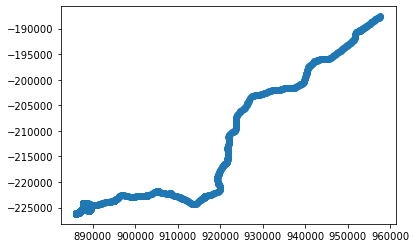

In [125]:
plt.scatter(gnssutm[0], gnssutm[1])

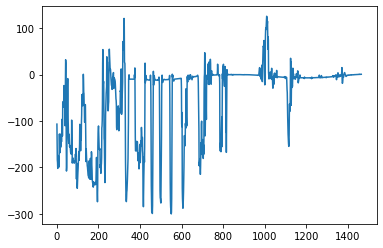

In [128]:
plt.plot(np.diff(gnssutm[0]))

In [36]:
gnssdayseconds

array([6.000e+01, 1.200e+02, 1.800e+02, ..., 8.622e+04, 8.628e+04,
       8.634e+04])

## Load  GEM2 data to be drift corrected

In [37]:
gem2inputfile = "/mnt/documents/Q2/AeNP6-09052021/transect/gem2/Q2-P6-transect-09052021-gem2-531-channel-thickness.csv"

In [38]:
gem2data = pd.read_csv(gem2inputfile, low_memory = False)

In [39]:
gem2data

time   record_id   longitude   latitude   xc  \
0      2021-05-09T07:03:11.937500           0         0.0        0.0  0.0   
1      2021-05-09T07:03:12.039062           1         0.0        0.0  0.0   
2      2021-05-09T07:03:12.140625           2         0.0        0.0  0.0   
3      2021-05-09T07:03:12.234375           3         0.0        0.0  0.0   
4      2021-05-09T07:03:12.335937           4         0.0        0.0  0.0   
...                           ...         ...         ...        ...  ...   
45617  2021-05-09T08:25:48.500000       45617         0.0        0.0  0.0   
45618  2021-05-09T08:25:48.601562       45618         0.0        0.0  0.0   
45619  2021-05-09T08:25:48.695312       45619         0.0        0.0  0.0   
45620  2021-05-09T08:25:48.796875       45620         0.0        0.0  0.0   
45621  2021-05-09T08:25:48.898437       45621         0.0        0.0  0.0   

        yc  f450Hz_hcp_i  f450Hz_hcp_q  f1530Hz_hcp_i  f1530Hz_hcp_q  \
0      0.0         1.170         1.099          1.073          1.173   
1      0.0         1.172         1.076          1.059          1.159   
2      0.0         1.112         1.120          1.118          1.159   
3      0.0         0.970         1.180          1.152          1.174   
4      0.0         0.959         1.102          1.160          1.174   
...    ...           ...           ...            ...            ...   
45617  0.0         0.844         1.211          1.097          1.165   
45618  0.0         0.633         1.206          1.086          1.167   
45619  0.0         0.628         1.150          1.130          1.150   
45620  0.0         0.938         1.070          1.165          1.156   
45621  0.0         1.193         1.091          1.184          1.171   

       f5310Hz_hcp_i   f5310Hz_hcp_q  f18330Hz_hcp_i   f18330Hz_hcp_q  \
0              1.161           1.166           1.167            1.164   
1              1.171           1.161           1.166            1.165   
2              1.173           1.166           1.162            1.167   
3              1.168           1.171           1.163            1.166   
4              1.157           1.166           1.163            1.167   
...              ...             ...             ...              ...   
45617          1.149           1.156           1.161            1.154   
45618          1.157           1.154           1.155            1.154   
45619          1.165           1.154           1.154            1.156   
45620          1.161           1.156           1.155            1.156   
45621          1.153           1.160           1.154            1.155   

       f63030Hz_hcp_i   f63030Hz_hcp_q  
0               1.167            1.158  
1               1.166            1.160  
2               1.167            1.164  
3               1.167            1.163  
4               1.165            1.160  
...               ...              ...  
45617           1.159            1.145  
45618           1.159            1.145  
45619           1.160            1.143  
45620           1.160            1.145  
45621           1.161            1.145  

[45622 rows x 16 columns]

In [40]:
gem2data.drop(gem2data[gem2data[" longitude"] == 0].index, inplace=True)
gem2data.drop(gem2data[gem2data[" latitude"] == 0].index, inplace=True)

In [41]:
f1530hz_hcp_i = [float(zi) for zi in gem2data[" f1530Hz_hcp_i"].values]

In [42]:
gem2utm = thetransform.transform(gem2data[" latitude"].values, gem2data[" longitude"].values)

In [43]:
gem2easting = gem2utm[0]
gem2northing = gem2utm[1]

Text(0.5, 1.0, 'uncorrected drift track - local coordinates')

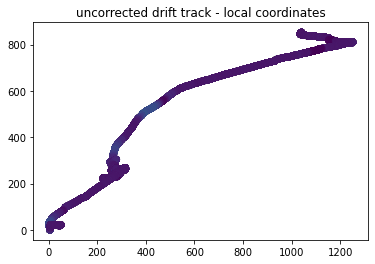

In [44]:
plt.scatter(gem2easting-np.min(gem2easting), gem2northing-min(gem2northing), c = f1530hz_hcp_i)
plt.title("uncorrected drift track - local coordinates")

In [99]:
gem2times = gem2data['time'].values
gem2dayseconds=[]
for thetime in gem2times[0:-2]:
    thisdate, thistime = thetime.split('T')
    #print(thistime)
    hour, minute, second = thistime.split(':')
    #print(len(thetime))
    #print(thetime)
    gem2dayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + float(second))

In [100]:
gem2dayseconds = np.round(gem2dayseconds, 4)

In [101]:
gem2times[-2]

'2021-05-09T08:25:47.898437'

In [102]:
## these are from PhD work in 2015
def trim_timeseries(t1, t2):
#trim a long timeseries to match a shorter one.
#t1 is the long series, t2 is the short sries
#returns a set of indices to apply to the longer
#timeseries dataset
    start = t2[0]
    end = t2[-1]
    
    print(start)
    
    lowidx = np.where(t1 < start)
    highidx = np.where(t1 > end)
    
    print(lowidx[0][-1])
    print(highidx[0][0])
    
    the_inds = np.arange(lowidx[0][-1], highidx[0][0]+1,1)
    
    
    #idx = (t1>=start)*(t1=<end)
    
    #the_inds = np.where(idx)
    #if t1[the_inds[0]] > start:
    #    inds2 = np.where(t1)
        
        
    return np.asarray(the_inds), start, end

In [103]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, gem2dayseconds)

25392.4375
424
512


In [104]:
gnss_trimmedtime = np.squeeze(gnss_trimmedtime)

In [105]:
gnss_trimmedtime[-1]

512

In [106]:
start

25392.4375

In [107]:
end

30347.7969

In [108]:
gnssdayseconds[511]

30300.0

In [109]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [110]:
trimmedtime[0]

25380.0

In [111]:
gem2dayseconds[0]

25392.4375

In [112]:
timesteps = np.arange(trimmedtime.min()-0.5, trimmedtime.max()+0.5, 0.0001)
timesteps = np.round(timesteps, 4)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)
    

In [113]:
timesteps[-1]

30360.5

In [114]:
gem2dayseconds[-1]

30347.7969

In [115]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in gem2dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])
    else:
        print(thistimeindex[0])

CPU times: user 19min 15s, sys: 2min 37s, total: 21min 52s
Wall time: 21min 53s


<function matplotlib.pyplot.scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, *, edgecolors=None, plotnonfinite=False, data=None, **kwargs)>

In [119]:
len(gem2easting)

45540

In [120]:
gnss_gem2_match_eastings = interp_east[timeindexes]
gnss_gem2_match_northings = interp_north[timeindexes]

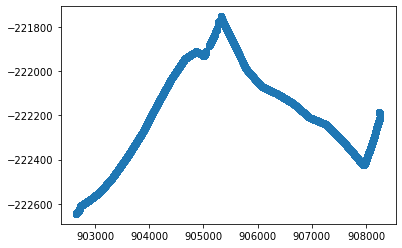

In [129]:
plt.scatter(gnss_gem2_match_eastings, gnss_gem2_match_northings)


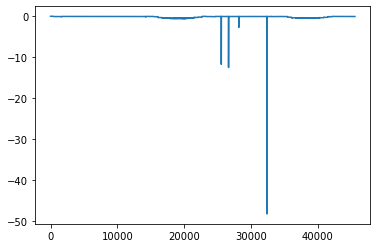

In [131]:
plt.plot(np.diff(gnss_gem2_match_eastings))

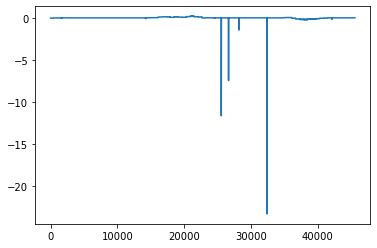

In [132]:
plt.plot(np.diff(gnss_gem2_match_northings))

In [122]:
gnss_gem2_match_eastings = np.squeeze(gnss_gem2_match_eastings)
gnss_gem2_match_northings = np.squeeze(gnss_gem2_match_northings)

In [123]:
local_gem2_east = gem2easting - gnss_gem2_match_eastings
local_gem2_north = gem2northing - gnss_gem2_match_northings

ValueError: operands could not be broadcast together with shapes (45540,) (45538,) 

In [90]:
local_gem2_east[0]

-24030.622993072262

In [91]:
local_gem2_north[0]

-7728.723859188089

In [85]:
world_gem2_east = local_gem2_east + gnss_gem2_match_eastings[0]
world_gem2_north = local_gem2_north + gnss_gem2_match_northings[0]

In [86]:
world_gem2_east.size

45540

In [87]:
gnss_gem2_match_eastings[0]

908245.0396456202

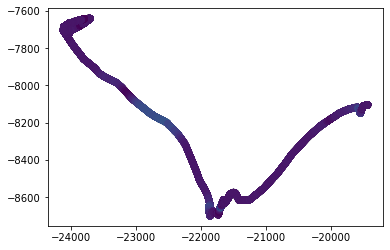

In [89]:
plt.scatter(local_gem2_east, local_gem2_north, c=f1530hz_hcp_i)

In [200]:
gem2_header = """AeN Q2 2021 P6 GEM2 measurements
GEM2-531 electromagnetic induction sounder
9 May 2021\nAdam Steer / Polona Itkin
Drift corrected: using GNSS data collected at an icefloe-fixed site
Coodinates expressed in NSIDC North Polar Stereographic (EPSG:3413)
Code for drift correction: https://gitlab.com/adamsteer/aen/-/blob/main/notebooks/drift%20correction.ipynb
Collected for the Nansen Legacy Project: https://arvenetternansen.com
Research Council of Norway project 276730
-----------------------------------------
"""

In [201]:
gem2_easting_df = pd.DataFrame({"easting": world_gem2_east})

In [202]:
gem2out = gem2data.copy()

In [203]:
gem2data.keys()

Index(['time', ' record_id', ' longitude', ' latitude', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

In [204]:
gem2out.drop(columns = [" longitude", " latitude"], inplace=True)
gem2out.keys()

Index(['time', ' record_id', ' xc', ' yc', ' f450Hz_hcp_i', ' f450Hz_hcp_q',
       ' f1530Hz_hcp_i', ' f1530Hz_hcp_q', ' f5310Hz_hcp_i', ' f5310Hz_hcp_q',
       ' f18330Hz_hcp_i', ' f18330Hz_hcp_q', ' f63030Hz_hcp_i',
       ' f63030Hz_hcp_q'],
      dtype='object')

In [205]:
gem2out.insert(2, "easting", world_gem2_east)

In [206]:
gem2out.insert(3, "northing", world_gem2_north)

In [207]:
gem2out.keys()

Index(['time', ' record_id', 'easting', 'northing', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

In [208]:
gem2_output = "/mnt/documents/Q2/AeNP6-09052021/transect/gem2/GEM2data-driftcorrected.csv"

In [209]:
with open(gem2_output, 'w') as outfile:
    outfile.write(gem2_header)
    

In [210]:
gem2out.to_csv(gem2_output, index=False, mode='a')

## Load Magnaprobe data to be drift corrected

Using the Alaska Magnaprobe we need to add 8 hours to timestamps...

In [211]:
magnaprobeinputfile = "/mnt/documents/Q2/AeNP6-09052021/transect/magnaprobe/P43552_P6.dat"


In [212]:
mpcolumns = ["TIMESTAMP","RECORD","Counter","DepthCm","BattVolts","latitude_a","latitude_b","Longitude_a","Longitude_b","fix_quality","nmbr_satellites","HDOP","altitudeB","DepthVolts","LatitudeDDDDD","LongitudeDDDDD","month","dayofmonth","hourofday","minutes","seconds","microseconds"]

In [213]:
mpdata = pd.read_csv(magnaprobeinputfile, skiprows=4, names = mpcolumns)

In [214]:
mpdepths = mpdata["DepthCm"].values / 100
mprawtimes = mpdata["TIMESTAMP"].values

fixedtime = []
for thetime in mprawtimes:
    try:
        fixedtime.append(datetime.strptime(thetime, "%Y-%m-%d %H:%M:%S.%f") + timedelta(hours = 9))
        
    except ValueError:
        fixedtime.append(datetime.strptime(thetime, "%Y-%m-%d %H:%M:%S") + timedelta(hours = 9))

mprawtimes = [datetime.strftime(thetime, "%Y-%m-%d %H:%M:%S.%f") for thetime in fixedtime]
mprawtimes[0].split(' ')
mprawdays = [thistime.split(' ')[0] for thistime in mprawtimes]
mptimes = [thistime.split(' ')[1] for thistime in mprawtimes]
mpdays = [datetime.strptime(thisday, "%Y-%m-%d") for thisday in mprawdays]
mptimes = np.array(mptimes)

In [215]:
mprawtimes[100]

'2021-05-10 07:08:55.360000'

In [216]:
datetime.strptime(mprawtimes[0], "%Y-%m-%d %H:%M:%S.%f") + timedelta(hours = 8)

datetime.datetime(2021, 5, 10, 15, 1, 10, 190000)

In [217]:
mpdaysfixed = [day + weekdelta for day in mpdays]

NameError: name 'weekdelta' is not defined

In [218]:
mptimes

array(['07:01:10.190000', '07:01:15.830000', '07:01:17.190000', ...,
       '14:20:17.440000', '14:50:09.070000', '14:59:40.800000'],
      dtype='<U15')

In [219]:
mp_dayseconds=[]
for thetime in mptimes:
    hour, minute, second = thetime.split(':')
    #print(len(thetime))
    #print(thetime)
    mp_dayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + float(second))

In [220]:
mp_dayseconds = np.round(mp_dayseconds, 2)
mp_dayseconds

array([25270.19, 25275.83, 25277.19, ..., 51617.44, 53409.07, 53980.8 ])

In [221]:
gnssdayseconds

array([6.000e+01, 1.200e+02, 1.800e+02, ..., 8.622e+04, 8.628e+04,
       8.634e+04])

In [222]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, mp_dayseconds)

25270.19
422
914


In [223]:
gnssdayseconds = np.array(gnssdayseconds)

In [224]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [225]:
timesteps = np.arange(trimmedtime.min()-0.01, trimmedtime.max()+0.01, 0.01)
timesteps = np.round(timesteps, 2)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)

In [226]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in mp_dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])

CPU times: user 2.93 s, sys: 3.61 ms, total: 2.93 s
Wall time: 2.93 s


In [227]:
len(timeindexes)

2170

In [228]:
len(mp_dayseconds)

2170

In [229]:
gnss_mp_match_eastings = np.squeeze(interp_east[timeindexes])
gnss_mp_match_northings = np.squeeze(interp_north[timeindexes])

Now get geo-data from the magnaprobe organised

In [230]:
mplatddd = mpdata["latitude_a"].values + (mpdata["latitude_b"].values / 60)
mplonddd = mpdata["Longitude_a"].values + (mpdata["Longitude_b"].values / 60)

In [231]:
mputm = thetransform.transform(mplatddd, mplonddd)

In [232]:
mpeasting = mputm[0]
mpnorthing = mputm[1]

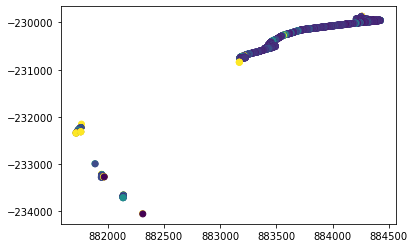

In [233]:
plt.scatter(mpeasting, mpnorthing, c = mpdata["DepthCm"])

Do the drift correction to local coordinates

In [234]:
local_mp_east = mpeasting - gnss_mp_match_eastings
local_mp_north = mpnorthing - gnss_mp_match_northings

In [235]:
len(mpeasting)

2170

In [236]:
len(gnss_mp_match_eastings)

2170

Convert back to world coordinates

In [237]:
world_mp_east = local_mp_east + gnss_gem2_match_eastings[0]
world_mp_north = local_mp_north + gnss_gem2_match_northings[0]

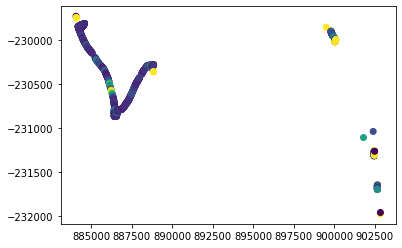

In [238]:
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"])

Export data to CSV

In [239]:
# first generate correct timestamps! Remembering the raw times are 1024 weeks out
mp_timefixed = []
i = 0
for thistime in mptimes:
    theday = datetime.strftime(mpdays[i],"%d-%m-%Y")
    thetimestamp = theday + "T" + thistime
    mp_timefixed.append(thetimestamp)
    i += 1

In [240]:
# Assemble a dataframe
mp_export = pd.DataFrame({"timestamp": mp_timefixed, 
                          "easting": world_mp_east, 
                          "northing": world_mp_north, 
                          "snowdepth": mpdata["DepthCm"]/100   })

In [241]:
mp_output = "/mnt/documents/Q2/AeNP6-09052021/transect/magnaprobe/MPdata-driftcorrected-datefixed.csv"

In [246]:
mp_header = """AeN Q2 2021 P6 Magnaprobe measurements
Snowhydro Magnaprobe NPI-1
9 May 2021\nAdam Steer / Polona Itkin
Time corrected: adding 9 hours to instrument timestamps to account for time zone settings
Drift corrected: using GNSS data collected at an icefloe-fixed site
Coordinates expressed in NSIDC North Polar Stereographic (EPSG:3413)
Code for date and drift correction: https://gitlab.com/adamsteer/aen/-/blob/main/notebooks/drift%20correction.ipynb
Collected for the Nansen Legacy Project: https://arvenetternansen.com
Research Council of Norway project 276730


"""

In [247]:
with open(mp_output, 'w') as outfile:
    outfile.write(mp_header)
    

In [248]:
mp_export.to_csv(mp_output, index=False, mode='a')

## Plot GEM2 and magnaprobe data together

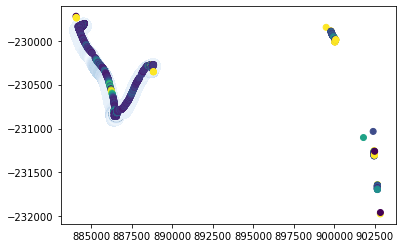

In [249]:
plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i, cmap = "Blues", s=200)
plt.scatter(world_mp_east+12, world_mp_north+5, c = mpdata["DepthCm"]/100)

## Load camera centers to be drift corrected

In [142]:
cameracentrefile = "/mnt/documents/ANAFI-USA/AeNQ2/AeNQ209052021/mapping-images/cameracentres.csv"

In [143]:
cameradata = pd.read_csv(cameracentrefile)

In [144]:
cameradata.drop(cameradata[cameradata["GPSLongitude"] == 0].index, inplace=True)
cameradata.drop(cameradata[cameradata["GPSLatitude"] == 0].index, inplace=True)

In [145]:
camerautm = thetransform.transform(cameradata["GPSLatitude"].values, cameradata["GPSLongitude"].values)

In [146]:
cameraeasting = camerautm[0]
cameranorthing = camerautm[1]

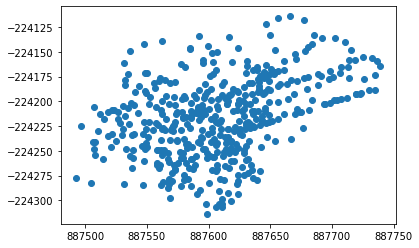

In [147]:
plt.scatter(cameraeasting, cameranorthing)

In [148]:
cameradata

SourceFile     DateTimeOriginal  SubSecTimeOriginal  GPSLatitude  \
0    jpg/P0792403.JPG  2021:05:09 16:36:00                 425    81.563195   
1    jpg/P0792404.JPG  2021:05:09 16:36:14                  51    81.563211   
2    jpg/P0792405.JPG  2021:05:09 16:36:20                 712    81.563242   
3    jpg/P0792406.JPG  2021:05:09 16:36:24                 181    81.563264   
4    jpg/P0792407.JPG  2021:05:09 16:36:30                 292    81.563279   
..                ...                  ...                 ...          ...   
454  jpg/P0822899.JPG  2021:05:09 17:14:30                  93    81.564059   
455  jpg/P0822900.JPG  2021:05:09 17:14:35                 441    81.563833   
456  jpg/P0822901.JPG  2021:05:09 17:14:41                  92    81.563711   
457  jpg/P0822902.JPG  2021:05:09 17:14:51                 425    81.563732   
458  jpg/P0822903.JPG  2021:05:09 17:14:54                 402    81.563781   

     GPSLongitude  GPSAltitude  AboveGroundAltitude  GPSXYAccuracy  \
0       30.826836     7.056257             3.528830       0.893756   
1       30.826721    13.220972             7.646163       0.648151   
2       30.826519    15.091534            10.189658       0.598164   
3       30.826364    17.537189            12.679988       0.676240   
4       30.826263    21.645445            16.976284       0.684105   
..            ...          ...                  ...            ...   
454     30.820198    38.400108            27.055349       1.069626   
455     30.819397    35.663937            25.056177       0.886172   
456     30.818770    30.295090            19.397270       0.773369   
457     30.818739    25.433708            11.727784       0.902718   
458     30.818390    26.076702            11.782609       1.024500   

     GPSZAccuracy  CameraPitchDegree  CameraRollDegree  CameraYawDegree  
0             1.8         -76.922646         -0.023820        93.117523  
1             1.2         -76.924095          0.012021        92.158020  
2             1.1         -88.749771          0.250945        91.944008  
3             1.3         -88.747894         -0.160944        92.329376  
4             1.3         -88.752434          0.416907        91.855919  
..            ...                ...               ...              ...  
454           1.8         -55.730293          0.041949       -16.775036  
455           1.5         -55.730675          0.001228         7.777160  
456           1.4         -55.724129         -0.012703         7.756098  
457           1.7         -55.730606         -0.017260         7.599850  
458           1.8         -55.723808          0.070762         7.759549  

[459 rows x 12 columns]

In [149]:
cam_utm = thetransform.transform(cameradata["GPSLatitude"], cameradata["GPSLongitude"])

In [150]:
cam_rawtimes = cameradata["DateTimeOriginal"].values
cam_rawtimes = cam_rawtimes
cam_rawtimes[0].split(' ')
cam_rawdays = [thistime.split(' ')[0] for thistime in cam_rawtimes]
cam_times = [thistime.split(' ')[1] for thistime in cam_rawtimes]
cam_days = [datetime.strptime(thisday, "%Y:%m:%d") for thisday in cam_rawdays]
cam_times = np.array(cam_times)

In [151]:
subseconds = [x / 10**len(str(x)) for x in cameradata["SubSecTimeOriginal"]]
subseconds[0:5]

[0.425, 0.51, 0.712, 0.181, 0.292]

In [152]:
cam_dayseconds=[]
i = 0
for thetime in cam_times:
    hour, minute, second = thetime.split(':')
    #print(len(thetime))
    #print(thetime)
    cam_dayseconds.append((int(int(hour)-2)*3600.0) + (int(minute) * 60.0) + float(subseconds[i]))
    i += 1

In [153]:
cam_dayseconds[0]

52560.425

In [154]:
gnssutm

array([[ 957636.46689047,  957529.66074692,  957388.88869429, ...,
         886103.72154285,  886104.23173357,  886104.74966133],
       [-187597.59781129, -187726.28476498, -187819.37968267, ...,
        -226220.91697185, -226222.2714737 , -226223.76440825]])

In [155]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, cam_dayseconds)

52560.425
890
929


In [156]:
gnssdayseconds = np.array(gnssdayseconds)

In [157]:
len(cam_dayseconds)

459

In [158]:
len(gnss_trimmedtime[0])

TypeError: object of type 'numpy.int64' has no len()

In [159]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [160]:
len(trimmedeast)

40

In [161]:
min(cam_dayseconds)

52560.181

In [162]:
max(cam_dayseconds)

54840.93

In [163]:
min(gnssdayseconds)

60.0

In [164]:
max(gnssdayseconds)

86340.0

In [165]:
timesteps = np.arange(trimmedtime.min()-0.5, trimmedtime.max()+0.5, 0.001)
timesteps = np.round(timesteps, 3)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)

In [166]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in cam_dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])
    else:
        print(thistimeindex[0])

CPU times: user 467 ms, sys: 373 µs, total: 467 ms
Wall time: 466 ms


In [167]:
gnss_cam_match_eastings = np.squeeze(interp_east[timeindexes])
gnss_cam_match_northings = np.squeeze(interp_north[timeindexes])

In [168]:
local_cam_east = cameraeasting - gnss_cam_match_eastings
local_cam_north = cameranorthing - gnss_cam_match_northings

In [169]:
local_cam_east[0]

-58.066074887057766

In [170]:
local_cam_north[0]

58.6958043887571

In [171]:
gnss_cam_match_northings[0] - gnss_cam_match_northings[-1]

93.0525007097749

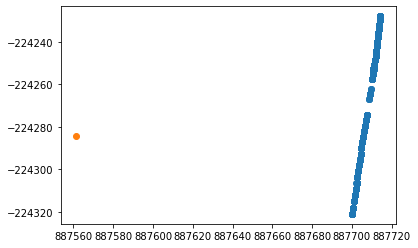

In [172]:
plt.scatter(gnss_cam_match_eastings, gnss_cam_match_northings)
plt.scatter(cameraeasting[-1], cameranorthing[-1])

In [173]:
cameraeasting[0]

887656.2522400625

In [174]:
gem2easting[0]

884214.4166525479

In [175]:
cameranorthing[0]

-224169.22886959434

In [176]:
gem2northing[0]

-229914.92121981175

In [177]:
local_gem2_east[0]

-24030.622993072262

In [178]:
local_mp_east[0]

NameError: name 'local_mp_east' is not defined

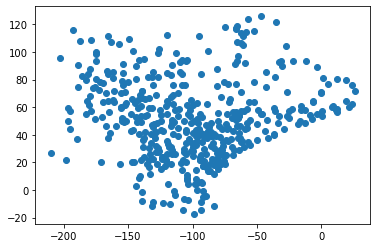

In [179]:
plt.scatter(local_cam_east, local_cam_north)

In [180]:
gnss_gem2_match_eastings[0]

908245.0396456202

In [181]:
local_gem2_east[0]

-24030.622993072262

In [182]:
world_cam_east = local_cam_east + gnss_cam_match_eastings[0]
world_cam_north = local_cam_north + gnss_cam_match_northings[0]

In [183]:
world_cam_east[0]

887656.2522400625

In [184]:
world_gem2_east[0]

884214.4166525479

NameError: name 'world_mp_east' is not defined

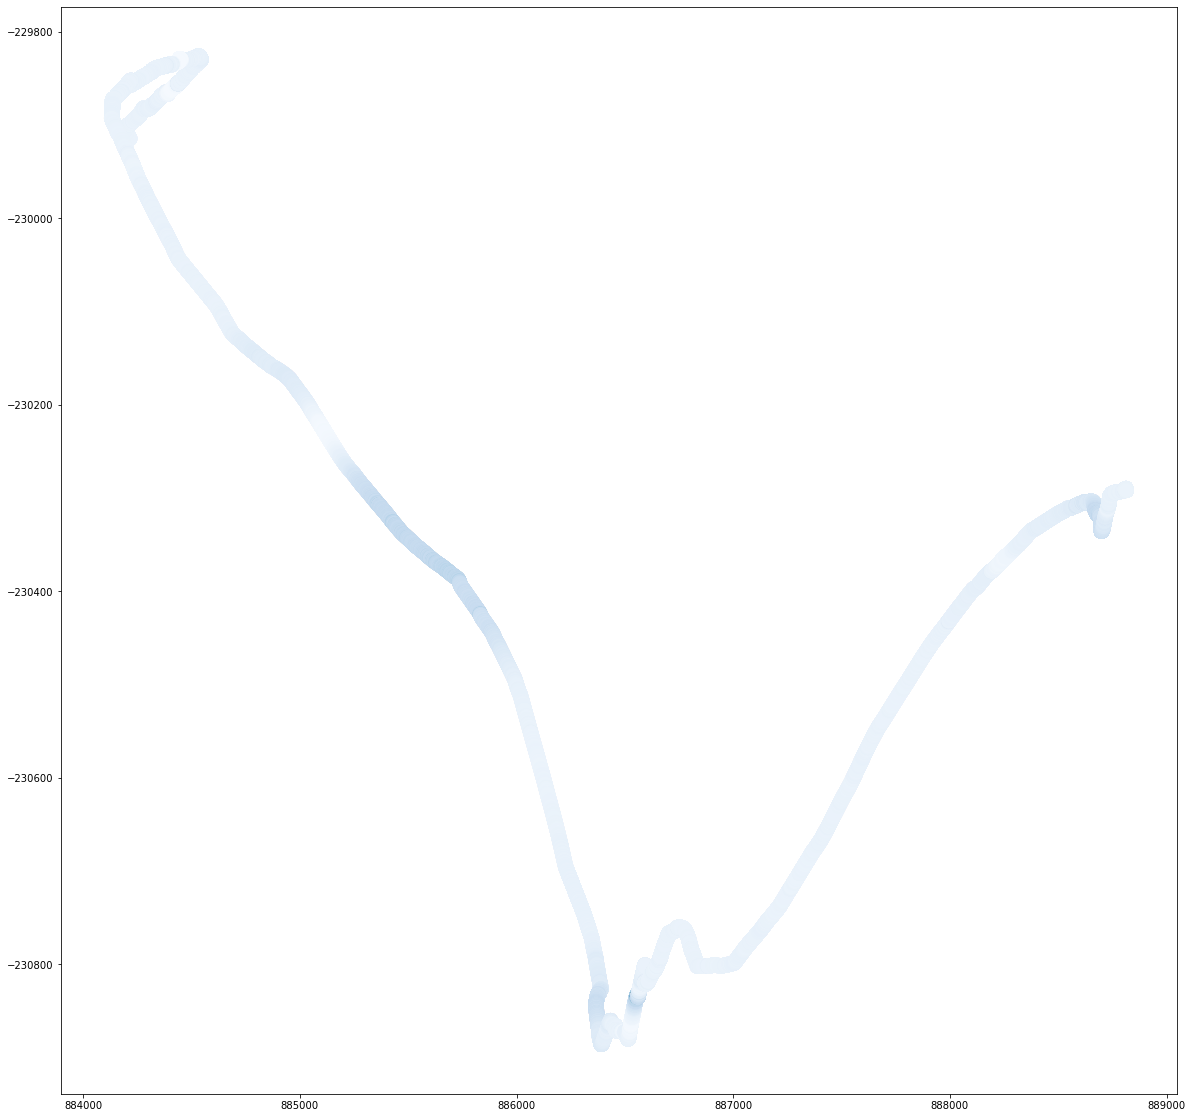

In [185]:
fig = plt.figure(figsize=(20,20))

#plt.scatter(gnssutm[0],gnssutm[1], s = 10, label = 'day 1 drift track')
#plt.scatter(gnss_cam_match_eastings, gnss_cam_match_northings, label = "camera match track")
#plt.scatter(gnss_mp_match_eastings, gnss_mp_match_northings)
#plt.scatter(gnss_gem2_match_eastings, gnss_gem2_match_northings)

plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i, cmap = "Blues", s=200, label = "GEM2")
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"]/100, label = "Magnaprobe")
plt.scatter(world_cam_east, world_cam_north, c = cameradata["AboveGroundAltitude"], label = "camera centres", cmap="Greens")
plt.legend()
plt.grid()
ax = plt.gca()
ax.set_aspect("equal")
plt.savefig("/mnt/documents/Q2/AeNP6-09052021/driftracks.png")

In [186]:
backtolatlon = pyproj.transformer.Transformer.from_proj(3413,4326)

In [187]:
cam_latlon = backtolatlon.transform(world_cam_east, world_cam_north)

In [188]:
cam_out = cameradata.copy()

In [189]:
cam_out["GPSLatitude"] = cam_latlon[0]

In [190]:
cam_out["GPSLongitude"] = cam_latlon[1]

In [191]:
mp_output_exiftool = "/mnt/documents/ANAFI-USA/AeNQ2/AeNQ209052021/driftcorrected-for-exiftool.csv"

In [192]:
cam_out.to_csv(mp_output_exiftool, index=False)

In [193]:
cam_out['GPSLatitude'][0] - cameradata["GPSLatitude"][0]

-1.7053025658242404e-13

In [194]:
cam_out['GPSLatitude'][0]

81.56319483330543

cam_o

In [195]:
cam_out_hag = cam_out.copy()

In [196]:
cam_out_hag["GPSAltitude"] = cam_out_hag["AboveGroundAltitude"]

In [197]:
cam_out_hag.drop(columns = ["AboveGroundAltitude"], inplace = True)

In [198]:
cam_output_exiftool_hag = "/mnt/documents/ANAFI-USA/AeNQ2/AeNQ209052021/driftcorrected-for-exiftool-HAG.csv"

In [199]:
cam_out_hag.to_csv(cam_output_exiftool_hag, index=False)